## Project idea 4:
### implement and test at least 6 different variants of Isomap for DGP: the three above, and at least three new ones of your own conception

In [61]:

import sys
import numpy as np
import math
import types
import matplotlib.pyplot as plt
import networkx as nx
import random
from math import e
from re import M, T


### Isomap for DGP


In [62]:
import re

from sympy import Q


def biconnected_graph(n,bool=False):
    "" "Generate a random biconnected graph with n nodes" ""
    X = nx.gnp_random_graph(n, 0.5, directed=False)
    while(not nx.is_biconnected(X)):
        X = nx.gnp_random_graph(n, 0.5, directed=False)
    list_pos={}
    for u in X.nodes():
        list_pos[u]=np.random.rand(2)
    for (u, v) in X.edges():
        X[u][v]['weight'] = np.linalg.norm(list_pos[u]-list_pos[v])
    if bool:
        nx.draw(X, with_labels=True)
        plt.show()
    return X, list_pos


def create_ampl_dat_grah(D, filename):
    "" "Create a .dat file for the ampl model" ""
    with open(filename, 'w') as file:
        file.write("# gen by python\n")
        file.write("param Kdim := 3;\n")
        file.write("param n := " + str(len(D.nodes())) + ";\n")
        file.write("param : E : c I :=\n")
        for (u, v) in D.edges():
            file.write(""+str(u+1) + " " + str(v+1) + " " + str(D[u][v]['weight'])+ " "+"1\n")
        file.write(";\n")
        file.close()

# Distance matrix creation algos
def floyd_warshall(D):
    D_prime= nx.to_numpy_array(D)
    "" "Floyd-Warshall algorithm that take an nx and return an array" ""
    for i in range(D_prime.shape[0]):
        for j in range(D_prime.shape[1]):
            if i != j and D_prime[i][j] == 0:
                D_prime[i][j] = math.inf
    for i in range(D_prime.shape[0]):
        for j in range(D_prime.shape[1]):
                for k in range(D_prime.shape[0]):
                    if i != k and j != k and i !=j:
                        if D_prime[i][j] > D_prime[i][k] + D_prime[k][j]:
                            D_prime[i][j] = D_prime[i][k] + D_prime[k][j]
    if np.array_equal(D_prime, D_prime.T):
        return D_prime
    else:
        print("error:The graph is not symetric")
        return None

def dijkstra(D):
    "" "Dijkstra algorithm that take an nx and a source node s and return an array" "" 
    D_prime= nx.to_numpy_array(D)
    n = D_prime.shape[0]
    D_new=[]
    for s in range(n):
        dist = [math.inf] * n
        dist[s] = 0
        Q = [i for i in range(n)]
        while len(Q) > 0:
            u = Q[0]
            for i in Q:
                if dist[i] < dist[u]:
                    u = i
            Q.remove(u)
            for v in range(n):
                if D_prime[u][v] != 0 and dist[v] > dist[u] + D_prime[u][v]:
                    dist[v] = dist[u] + D_prime[u][v]
        D_new.append(dist)
    D_new = np.array(D_new)

    if np.array_equal(D_new, D_new.T):
        return D_new
    else:
        print("error:The graph is not symetric")
        return None
    
def dijkstra_for_kmeans(D,list):
    "" "Dijkstra algorithm that take an nx and a source node s and return an array" "" 
    D_prime= nx.to_numpy_array(D)
    n = D_prime.shape[0]
    D_new=[]
    for s in list:
        dist = [math.inf] * n
        dist[s] = 0
        Q = list.copy()
        while len(Q) > 0:
            u = Q[0]
            for i in Q:
                if dist[i] < dist[u]:
                    u = i
            Q.remove(u)
            for v in range(n):
                if D_prime[u][v] != 0 and dist[v] > dist[u] + D_prime[u][v]:
                    dist[v] = dist[u] + D_prime[u][v]
        D_new.append(dist)
    D_new = np.array(D_new)
    return D_new

    
def poor_djkstra(D):
    D_prime= nx.to_numpy_array(D)
    n = D_prime.shape[0]
    D_new=[]
    for s in range(n):
        dist = [math.inf] * n
        dist[s] = 0
        Q = [i for i in range(n)]
        while len(Q) > 0:
            u = Q[0]
            for i in Q:
                if dist[i] != math.inf:
                    u = i
                    break
            Q.remove(u)
            for v in range(n):
                if D_prime[u][v] != 0 and dist[v] == math.inf:
                    dist[v] = dist[u] + D_prime[u][v]
        D_new.append(dist)
    D_new = np.array(D_new)

    for i in range(D_new.shape[0]):
        for j in range(i+1):
            D_new[i][j] = D_new[j][i]

    if np.array_equal(D_new, D_new.T):
        return D_new
    else:
        print("error:The graph is not symetric")
        return None
    





def extract_data(path):
    # Définir le chemin vers le fichier rlz
    fichier_rlz = path

    # Initialiser une liste pour stocker les données
    donnees = []

    # Lire le fichier ligne par ligne
    with open(fichier_rlz, 'r') as f:
        lignes = f.readlines()

    # Parcourir les lignes et extraire les données
    for ligne in lignes:
        # Ignorer les lignes vides ou les lignes de commentaire commençant par ':'
        if ligne.strip() == '' or ligne.strip().startswith(':') or ligne.strip().startswith('x') or ligne.strip().startswith(';'):
            continue
        # Séparer la ligne en colonnes en utilisant l'espace comme délimiteur
        colonnes = ligne.split()
        # Convertir les valeurs en nombres flottants
        valeurs = [float(colonne) for colonne in colonnes[1:]]  # Ignorer le numéro de ligne dans la première colonne
        # Ajouter les valeurs à la liste de données
        donnees.append(valeurs)

    # Convertir la liste de données en tableau numpy
    import numpy as np
    tableau_donnees = np.array(donnees)
    return tableau_donnees


## return the distance matrix of a realization
def distanceMatrix(x, p=2):
    n = len(x[:,0])
    D = np.zeros((n,n))
    for u in range(n-1):
        for v in range(u+1,n):
            D[u,v] = np.linalg.norm(np.subtract(x[u,:],x[v,:]), ord=p)
            D[v,u] = D[u,v]
    return D

## convert a distance matrix to a Gram matrix
def dist2Gram(D):
    n = D.shape[0]
    J = np.identity(n) - (1.0/n)*np.ones((n,n))
    G = -0.5 * np.dot(J,np.dot(np.square(D), J))
    return G

## factor a square matrix
def factor(A):
    n = A.shape[0]
    (evals,evecs) = np.linalg.eigh(A)
    evals[evals < 0] = 0  # closest SDP matrix
    X = evecs #np.transpose(evecs)
    sqrootdiag = np.eye(n)
    for i in range(n):
        sqrootdiag[i,i] = math.sqrt(evals[i])
    X = X.dot(sqrootdiag)
    return np.fliplr(X)

## classic Multidimensional scaling
def MDS(B, eps = 1e-9):
    n = B.shape[0]
    x = factor(B)
    (evals,evecs) = np.linalg.eigh(x)
    K = len(evals[evals > eps])
    if K < n:
        # only first K columns
        x = x[:,0:K]
    return x

## principal component analysis
def PCA(B, K):
    x = factor(B)
    n = B.shape[0]
    if isinstance(K, str):
        K = n
    if K < n:
        # only first K columns
        x = x[:,0:K]
    return x

def complete_PCA_part(D,eps,representation=True):
    G=dist2Gram(D)
    X=MDS(G,eps)
    n=X.shape[0]
    # K=X.shape[1]
    K=3
    # print("dimension can be reduced from", n, "to", K)

    if representation:
        if K > 3:
            K = 3
        elif K < 2:
            K = 2
        print("representing in", K, "dimensions")

        X = PCA(G,K)

        if K == 2:
            plt.scatter(X[:,0], X[:,1])
        elif K == 3:
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.scatter(X[:,0], X[:,1], X[:,2])
            ax.plot(X[:,0], X[:,1], X[:,2])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')

        plt.show()
    else:
        X=PCA(G,K)
    return X

def k_means_method(D):
    D_prime= nx.to_numpy_array(D)

    # Obtenir le degré de chaque noeud
    degrees = D.degree()

    # Trier les noeuds par degré en ordre décroissant
    sorted_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)
    
    # Les noeuds les plus connectés sont les premiers de la liste triée
    most_connected_nodes = sorted_nodes[0]
    Q=[i for i in range(D_prime.shape[0])]
    centroids=[]
    reached_list=[]
    for i in range(len(sorted_nodes)):
        add=False
        if len(Q) == 0:
            break
        u = sorted_nodes[i][0]
        reached=[]
        for v in Q:
            if D_prime[u][v] != 0:
                Q.remove(v)
                reached.append(v)
                add=True
        if add:
            centroids.append(u)
            reached_list.append(reached)
    list=[u for u in centroids]
    path_between_centroids=dijkstra_for_kmeans(D,list)
    for i in range(D_prime.shape[0]):
        i_centroid = next((index for index, sublist in enumerate(reached_list) if i in sublist), None)
        for j in range(i+1):
            j_centroid = next((index for index, sublist in enumerate(reached_list) if j in sublist), None)
            if i != j and D_prime[i][j] == 0:
                D_prime[i][j]=D_prime[i][i_centroid]+D_prime[j][j_centroid]+path_between_centroids[i_centroid][j_centroid]
                D_prime[j][i]=D_prime[i][j]
            elif i != j and D_prime[i][j] != 0:
                D_prime[i][j]=D_prime[i][j]
    
    if np.array_equal(D_prime, D_prime.T):
        return D_prime
    else:
        print("error:The graph is not symetric")
        return None


def random_method(D):
    D_prime= nx.to_numpy_array(D)
    seen=[]
    u=np.random.randint(0, D_prime.shape[0])
    seen.append(u)
    while len(seen) < D_prime.shape[0]:
        # print(f'new node {u} in the seen list {seen}')
        v=0
        weight=0
        Q=[i for i in range(D_prime.shape[0])]
        # print(Q)
        Q.remove(u)
        for k in range(D_prime.shape[0]):
            if D_prime[u][k] != 0:
                Q.remove(k)
                v=k
        weight=D_prime[u][v]

        already_passed=[]
        while len(Q) > 0:
            # print(f'new node {v}, Q list {Q}')
            ancient_v=v
            for k in range(D_prime.shape[0]):
                if D_prime[u][k] == 0 and D_prime[v][k] != 0 and u != k and (k not in already_passed):
                    already_passed=[]
                    Q.remove(k)
                    v=k
                    D_prime[u][k]=weight+D_prime[v][k]
                    D_prime[k][u]=weight+D_prime[v][k]
                    weight=D_prime[u][k]
            if ancient_v==v:
                for k in range(D_prime.shape[0]):
                    if D_prime[u][k] != 0 and (k not in already_passed):
                        # print(f'case ancient_v k={k}, alredy_passed={already_passed}')
                        already_passed.append(k)
                        v=k
                        # print(v)
                        weight=D_prime[u][k]
                        break
        while True:
            u=np.random.randint(0, D_prime.shape[0])
            if u not in seen:
                seen.append(u)
                break
            # print(f'there is an error with the node {u} and the node {v}')
    return D_prime      

def highest_degree_vertex(G):
    """Find the vertex with the highest degree in G."""
    max_degree_node = max(G.nodes, key=G.degree)
    return max_degree_node

def sample_from_sphere(center, distance, dimension):
    """Sample a point from a sphere centered at 'center' with a given 'distance' in a space of 'dimension' dimensions."""
    realiz_sample = np.random.normal(size=dimension)
    realiz_sample /= np.linalg.norm(realiz_sample)  # Normalize to get a unit vector
    point = center + distance * realiz_sample
    return point

def BFS(G, K=3):
    """Modified BFS that samples each node's position in a K-dimensional space based on its connections."""
    root = highest_degree_vertex(G)
    positions = {root: np.zeros(K)}  # Starting at the origin for the root
    explored = {root}
    Q = [root]

    while Q:
        v = Q.pop(0)
        x_v = positions[v]

        for w in G.neighbors(v):
            if w not in explored:
                explored.add(w)
                dvw = G[v][w]['weight']
                x_w = sample_from_sphere(x_v, dvw, K)
                positions[w] = x_w
                Q.append(w)

    # Complete the graph by adding missing edges
    for u in G.nodes():
        for v in G.nodes():
            if u != v and not G.has_edge(u, v):
                # Add an edge with weight equal to the Euclidean distance between u and v
                distance = np.linalg.norm(positions[u] - positions[v])
                G.add_edge(u, v, weight=distance)

    return calculate_distance_matrix(positions)

def calculate_distance_matrix(positions):
    """Calculate the N x N distance matrix from the positions."""
    nodes = list(positions.keys())
    n = len(nodes)
    distance_matrix = np.zeros((n, n))

    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i != j:
                distance_matrix[i, j] = np.linalg.norm(positions[u] - positions[v])
            else:
                distance_matrix[i, j] = 0  # Distance to itself is 0

    return distance_matrix


In [63]:

def complete_isomap(method,D,eps,representation=False):
    if method=="floyd_warshall":
        D_prime=floyd_warshall(D)
    elif method=="dijkstra":
        D_prime=dijkstra(D)
    elif method=="poor_djkstra":
        D_prime=poor_djkstra(D)
    elif method=="k_means":
        D_prime=k_means_method(D)
    elif method=="random":
        D_prime=random_method(D)
    elif method=="BFS":
        D_prime=BFS(D)
    else:
        print("method not found")
        return None
    X=complete_PCA_part(D_prime,eps,representation)
    return X

D,list_nodes=biconnected_graph(10)
create_ampl_dat_grah(D,"graph.dat")
X=complete_isomap("floyd_warshall",D,eps=1e-4,representation=True)
# D=extract_data("./dgp_graph.rlz")


## Applicative Part

In [ ]:
from math import dist
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import random as rnd
import networkx as nx 
import matplotlib.pyplot as plt

rnd.seed(42)

class ISOPredictor(nn.Module):
    def __init__(self, k_dim, h_dim):
        super(ISOPredictor, self).__init__()
        self.h1 = nn.Linear(k_dim, h_dim)
        self.h2 = nn.Linear(h_dim, k_dim)
        self.normalize = nn.LayerNorm(k_dim)
        self.l_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.l_relu(self.h1(x))
        # x = self.l_relu(self.h2(x))
        x= self.h2(x)
        # x = self.normalize(x)
        return x

def train(model, dataloader, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        for data, target in dataloader:
            print(data.shape)
            optimizer.zero_grad()
            output = model(data.float())
            loss = loss_fn(output, target.float())
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def infer(model, input_data):
    model.eval()
    with torch.no_grad():
        output = model(input_data.float())
    return output

def simulate_net_moving(current_position, mu=0.5, sigma=0.25):
    v_const=(np.random.uniform(0,10),np.random.uniform(0,10))
    next_state_pos = {node: (pos[0]+v_const[0],pos[1]+v_const[1]) for node, pos in current_position.items()}
    return next_state_pos

def position_to_isomap(positions):
    nodes = list(positions.keys()) ## question what is in the nodes the different moving sensors or the different positions
    n = len(nodes)
    distance_matrix = np.zeros((n, n))
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i != j:
                distance_matrix[i, j] = np.linalg.norm(np.array(positions[u]) - np.array(positions[v])) ##make it absolute
            else:
                distance_matrix[i, j] = 0
    distance_matrix = nx.from_numpy_array(distance_matrix)
    
    isomap = complete_isomap("floyd_warshall",distance_matrix,eps=1e-4,representation=False)

    return isomap

def isomap_batcher(initial_position, initial_isomap, timeline):
    iso_batch = []
    position = initial_position
    isomap = initial_isomap
    iso_batch.append(torch.tensor(isomap.copy()))
    for t in timeline:
        position = simulate_net_moving(position, mu=5, sigma=10)
        isomap = position_to_isomap(position)
        iso_batch.append(torch.tensor(isomap.copy()))
    return iso_batch

def feed_dataloader(iso_batch):
    feed_load = [(iso_batch[i], iso_batch[i+1]) for i in range(len(iso_batch)-1)]
    return torch.utils.data.DataLoader(feed_load, batch_size=10, shuffle=True) ## why batch size =10?


def inference(model, init_position, horizon, mu=5, sigma=10, plot_loss: bool = True):
    """
    Simulates movement based on a model and tracks the Mean Squared Error (MSE) loss over time.
    
    Parameters:
    - model: The predictive model to be used for inference.
    - init_position: The initial position to start the simulation from.
    - horizon: Number of steps to simulate.
    - mu, sigma: Parameters for the simulation of movement (mean and standard deviation).
    - plot_loss: If True, plots the evolution of the MSE loss over time.
    """

    gt_position = init_position
    gt_isomap = position_to_isomap(gt_position)
    
    mse_losses = []

    for step in range(horizon):

        isomap_tensor = torch.tensor(gt_isomap.copy()).float()

        predicted_isomap = infer(model,isomap_tensor.unsqueeze(0))

        gt_position = simulate_net_moving(gt_position, mu, sigma)  
        
        gt_isomap = position_to_isomap(gt_position)
        
        # Calculate MSE loss.
        mse = torch.mean((predicted_isomap.squeeze() - torch.tensor(gt_isomap.copy()).float()) ** 2).item()
        mse_losses.append(mse)  
        
        print(f'Step {step+1}, MSE: {mse}')
        
    if plot_loss:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, horizon + 1), mse_losses, marker='o', linestyle='-', color='blue')
        plt.title('Evolution of MSE Loss Over Time')
        plt.xlabel('Simulation Step')
        plt.ylabel('MSE Loss')
        plt.grid(True)
        plt.show()


In [ ]:
n_nodes = 10
# Dimension of ISOMAP input/output
h_dim = 64  # Dimension of hidden layer
learning_rate = 0.001
epochs = 50
timeline = np.arange(0, 1000, 1)

G,list_nodes = biconnected_graph(n_nodes)

initial_position, initial_isomap = list_nodes, complete_isomap("floyd_warshall",G,eps=1e-4,representation=False)
# print(initial_position, initial_isomap)
k_dim = initial_isomap.shape[1]
iso_batch = isomap_batcher(initial_position, initial_isomap, timeline)
print(f'shape is {iso_batch[0].shape}')
dataloader = feed_dataloader(iso_batch)
print(dataloader)
model = ISOPredictor(k_dim, h_dim)
train(model, dataloader, epochs, learning_rate)

shape is torch.Size([10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size([10, 10, 3])
torch.Size(

Step 1, MSE: 3.360566097398987e-06
Step 2, MSE: 3.3605651879042853e-06
Step 3, MSE: 3.3605667795200134e-06
Step 4, MSE: 3.360566097398987e-06
Step 5, MSE: 3.360566097398987e-06
Step 6, MSE: 3.3605667795200134e-06
Step 7, MSE: 3.360566097398987e-06
Step 8, MSE: 3.360566097398987e-06
Step 9, MSE: 3.360566097398987e-06
Step 10, MSE: 3.360566097398987e-06
Step 11, MSE: 3.360566097398987e-06
Step 12, MSE: 3.3605667795200134e-06
Step 13, MSE: 3.3605667795200134e-06
Step 14, MSE: 3.3605667795200134e-06
Step 15, MSE: 3.3605667795200134e-06


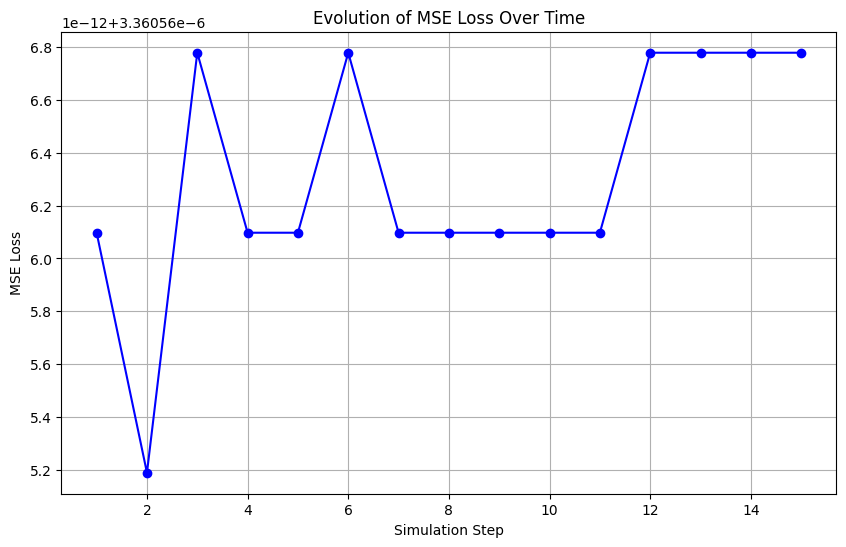

In [ ]:
#inference 
horizon = 15  # Number of steps to simulate in the future
inference(model, initial_position, horizon)